# Non Local Means Denoising

Applying Non-Local Means denoising...
Denoising took 7.74 seconds
PSNR (noisy): 20.54 dB
PSNR (denoised): 26.07 dB


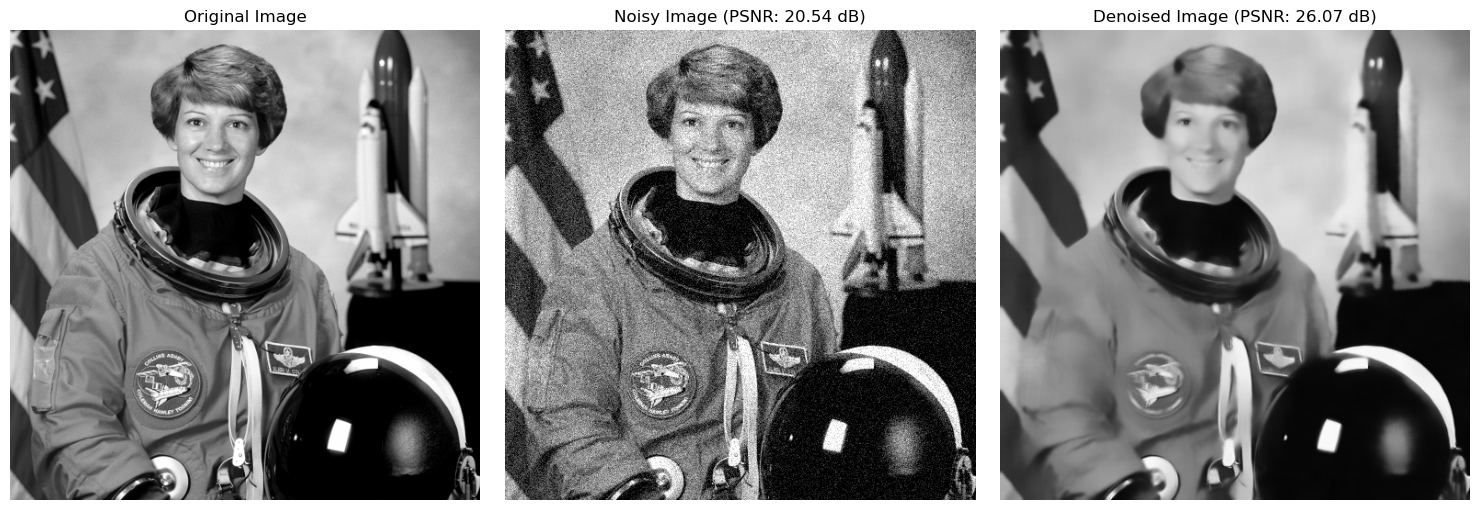


Image Statistics:
Original - Mean: 0.449, Std: 0.292
Noisy - Mean: 0.456, Std: 0.296
Denoised - Mean: 0.454, Std: 0.274


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from skimage import data, util
import time

class NonLocalMeansDenoising:
    """
    Non-Local Means Denoising implementation in PyTorch.
    
    This implementation uses GPU acceleration for faster processing of large images.
    """
    
    def __init__(self, h=10, patch_size=7, search_size=21, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Initialize NLM denoiser.
        
        Args:
            h: Filtering parameter controlling the decay of weights (higher = more smoothing)
            patch_size: Size of patches for comparison (should be odd)
            search_size: Size of search window (should be odd)
            device: Device to run computations on ('cuda' or 'cpu')
        """
        self.h = h
        self.patch_size = patch_size
        self.search_size = search_size
        self.device = device
        self.patch_radius = patch_size // 2
        self.search_radius = search_size // 2
        
    def extract_patches(self, image, patch_size):
        """
        Extract all overlapping patches from the image using unfold.
        
        Args:
            image: Input image tensor (B, C, H, W)
            patch_size: Size of patches to extract
            
        Returns:
            Patches tensor (B, C, H, W, patch_size, patch_size)
        """
        # Use unfold to extract patches efficiently
        patches = F.unfold(image, kernel_size=patch_size, padding=patch_size//2)
        B, C_ps_ps, HW = patches.shape
        H = image.shape[2]
        W = image.shape[3]
        C = image.shape[1]
        
        # Reshape to (B, C, H, W, patch_size, patch_size)
        patches = patches.view(B, C, patch_size, patch_size, H, W)
        patches = patches.permute(0, 1, 4, 5, 2, 3)
        
        return patches
    
    def compute_weights(self, patches_i, patches_j, h):
        """
        Compute weights between patch pairs.
        
        Args:
            patches_i: Reference patches (B, C, patch_size, patch_size)
            patches_j: Comparison patches (B, C, patch_size, patch_size)
            h: Filtering parameter
            
        Returns:
            Weights tensor
        """
        # Compute squared L2 distance between patches
        diff = patches_i - patches_j
        dist_sq = (diff * diff).sum(dim=(1, 2, 3))
        
        # Apply exponential weighting
        weights = torch.exp(-dist_sq / (h * h))
        
        return weights
    
    def denoise_pixel(self, image, i, j):
        """
        Denoise a single pixel using NLM algorithm.
        
        Args:
            image: Input noisy image tensor
            i, j: Pixel coordinates
            
        Returns:
            Denoised pixel value
        """
        H, W = image.shape[-2:]
        
        # Define search window boundaries
        i_min = max(0, i - self.search_radius)
        i_max = min(H, i + self.search_radius + 1)
        j_min = max(0, j - self.search_radius)
        j_max = min(W, j + self.search_radius + 1)
        
        # Extract reference patch
        pi_min = max(0, i - self.patch_radius)
        pi_max = min(H, i + self.patch_radius + 1)
        pj_min = max(0, j - self.patch_radius)
        pj_max = min(W, j + self.patch_radius + 1)
        
        patch_ref = image[..., pi_min:pi_max, pj_min:pj_max]
        
        # Initialize weighted sum and weight sum
        weighted_sum = torch.zeros_like(image[..., i, j])
        weight_sum = torch.zeros(1).to(self.device)
        
        # Search for similar patches
        for si in range(i_min, i_max):
            for sj in range(j_min, j_max):
                # Extract comparison patch
                psi_min = max(0, si - self.patch_radius)
                psi_max = min(H, si + self.patch_radius + 1)
                psj_min = max(0, sj - self.patch_radius)
                psj_max = min(W, sj + self.patch_radius + 1)
                
                patch_comp = image[..., psi_min:psi_max, psj_min:psj_max]
                
                # Ensure patches have same size (handle boundary cases)
                if patch_ref.shape == patch_comp.shape:
                    # Compute weight
                    diff = patch_ref - patch_comp
                    dist_sq = (diff * diff).sum()
                    weight = torch.exp(-dist_sq / (self.h * self.h))
                    
                    # Accumulate weighted sum
                    weighted_sum += weight * image[..., si, sj]
                    weight_sum += weight
        
        # Normalize
        if weight_sum > 0:
            return weighted_sum / weight_sum
        else:
            return image[..., i, j]
    
    def denoise(self, image):
        """
        Denoise the entire image using NLM algorithm.
        
        Args:
            image: Input noisy image (numpy array or torch tensor)
            
        Returns:
            Denoised image (numpy array)
        """
        # Convert to tensor if necessary
        if isinstance(image, np.ndarray):
            was_numpy = True
            original_shape = image.shape
            if len(image.shape) == 2:
                image = image[np.newaxis, np.newaxis, :, :]
            elif len(image.shape) == 3:
                image = np.transpose(image, (2, 0, 1))[np.newaxis, :]
            image_tensor = torch.from_numpy(image).float().to(self.device)
        else:
            was_numpy = False
            image_tensor = image.to(self.device)
        
        B, C, H, W = image_tensor.shape
        denoised = torch.zeros_like(image_tensor)
        
        # Process each pixel
        for i in range(H):
            for j in range(W):
                denoised[..., i, j] = self.denoise_pixel(image_tensor, i, j)
        
        # Convert back to numpy if necessary
        if was_numpy:
            denoised = denoised.cpu().numpy()
            if len(original_shape) == 2:
                denoised = denoised[0, 0, :, :]
            elif len(original_shape) == 3:
                denoised = np.transpose(denoised[0], (1, 2, 0))
        
        return denoised

class FastNLMDenoising:
    """
    Faster implementation using vectorized operations.
    """
    
    def __init__(self, h=10, patch_size=7, search_size=21, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.h = h
        self.patch_size = patch_size
        self.search_size = search_size
        self.device = device
    
    def denoise(self, image):
        """
        Fast vectorized NLM denoising.
        """
        if isinstance(image, np.ndarray):
            was_numpy = True
            original_dtype = image.dtype
            image = torch.from_numpy(image).float().to(self.device)
            if len(image.shape) == 2:
                image = image.unsqueeze(0).unsqueeze(0)
        else:
            was_numpy = False
            image = image.to(self.device)
        
        B, C, H, W = image.shape
        pad_size = self.search_size // 2
        
        # Pad image
        padded = F.pad(image, (pad_size, pad_size, pad_size, pad_size), mode='reflect')
        
        # Extract all patches using unfold
        patches = F.unfold(padded, kernel_size=self.patch_size, stride=1)
        patches = patches.view(B, C * self.patch_size * self.patch_size, H + 2*pad_size - self.patch_size + 1, W + 2*pad_size - self.patch_size + 1)
        
        denoised = torch.zeros_like(image)
        
        # Process each pixel
        for i in range(H):
            for j in range(W):
                # Get reference patch
                ref_patch = patches[:, :, i + pad_size - self.patch_size//2, j + pad_size - self.patch_size//2]
                ref_patch = ref_patch.view(B, C * self.patch_size * self.patch_size, 1, 1)
                
                # Define search region
                si_min = max(0, i)
                si_max = min(H + 2*pad_size - self.patch_size + 1, i + self.search_size)
                sj_min = max(0, j)
                sj_max = min(W + 2*pad_size - self.patch_size + 1, j + self.search_size)
                
                # Get search region patches
                search_patches = patches[:, :, si_min:si_max, sj_min:sj_max]
                
                # Compute distances
                diff = search_patches - ref_patch
                distances = (diff * diff).sum(dim=1, keepdim=True)
                
                # Compute weights
                weights = torch.exp(-distances / (self.h * self.h))
                
                # Get corresponding pixel values
                search_region = padded[:, :, si_min:si_max+self.patch_size-1, sj_min:sj_max+self.patch_size-1]
                center_pixels = search_region[:, :, self.patch_size//2:si_max-si_min+self.patch_size//2, 
                                             self.patch_size//2:sj_max-sj_min+self.patch_size//2]
                
                # Weighted average
                weighted_sum = (weights * center_pixels).sum(dim=(2, 3))
                weight_sum = weights.sum(dim=(2, 3)) + 1e-8
                
                denoised[:, :, i, j] = weighted_sum / weight_sum
        
        if was_numpy:
            denoised = denoised[0, 0].cpu().numpy()
            denoised = np.clip(denoised, 0, 1).astype(original_dtype)
        
        return denoised

# Example usage and demonstration
def demonstrate_nlm():
    """
    Demonstrate NLM denoising on a sample image.
    """
    # Load a sample image
    image = data.astronaut()
    image = util.img_as_float(image)
    
    # Convert to grayscale for simplicity
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)
    
    # Add Gaussian noise
    noise_std = 0.1
    noisy_image = image + np.random.normal(0, noise_std, image.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    
    # Apply NLM denoising
    print("Applying Non-Local Means denoising...")
    nlm = FastNLMDenoising(h=10*noise_std, patch_size=7, search_size=21)
    
    start_time = time.time()
    denoised_image = nlm.denoise(noisy_image)
    print(f"Denoising took {time.time() - start_time:.2f} seconds")
    
    # Calculate PSNR
    def psnr(img1, img2):
        mse = np.mean((img1 - img2) ** 2)
        if mse == 0:
            return float('inf')
        max_pixel = 1.0
        return 20 * np.log10(max_pixel / np.sqrt(mse))
    
    psnr_noisy = psnr(image, noisy_image)
    psnr_denoised = psnr(image, denoised_image)
    
    print(f"PSNR (noisy): {psnr_noisy:.2f} dB")
    print(f"PSNR (denoised): {psnr_denoised:.2f} dB")
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(noisy_image, cmap='gray')
    axes[1].set_title(f'Noisy Image (PSNR: {psnr_noisy:.2f} dB)')
    axes[1].axis('off')
    
    axes[2].imshow(denoised_image, cmap='gray')
    axes[2].set_title(f'Denoised Image (PSNR: {psnr_denoised:.2f} dB)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return image, noisy_image, denoised_image

if __name__ == "__main__":
    # Run demonstration
    original, noisy, denoised = demonstrate_nlm()
    
    # Additional analysis
    print("\nImage Statistics:")
    print(f"Original - Mean: {np.mean(original):.3f}, Std: {np.std(original):.3f}")
    print(f"Noisy - Mean: {np.mean(noisy):.3f}, Std: {np.std(noisy):.3f}")
    print(f"Denoised - Mean: {np.mean(denoised):.3f}, Std: {np.std(denoised):.3f}")